In [2]:
import pandas as pd
import geopandas as gpd
import sqlalchemy


import cabi.etl.transform as t
import cabi.model as m
import cabi.etl.load as l
import cabi.viz as v


from statsmodels.tsa.statespace.sarimax import SARIMAX


from tqdm import tqdm_notebook



## Prototyping the Workflow For Modeling Each ANC
### Notes:
- How important is accuracy vs. anomaly detection? (depends on how fast you can rebalance, if you can quickly deploy/pull bikes from any location then anomaly detection has some value, but if for example it takes three hours to redeploy, the spike lasts for 30 minutes, and you're only able to anticipate it 1 hr. in advance, this is less useful, and it would be better to predict general accuracy)

- This also poses an interesting business workflow approach: making a weekly/ daily deployment plan, and supplementing with walk-forward data

- Consider scipy optimize

- We are interested most in:

    1) How Well can We Predict During a Given Day (Direct Deployment)
    
        - How many Rebalancing periods are there per day? (Looks like around 2 usually)
        - Can we consistently predict short term spikes (Also what is the impact of short term spike on the whole system -- looking for cascade effect over simultaneous event implies need higher frequency view)
        
        
    2) How Well can We Forecast the next 2 weeks or month (Employee Scheduling)
    
    3) Do different areas have distinct rebalancing patterns at different points in time or is there an increasing or decreasing trend component anywhere over time?
    
    
## Cross-Validation Strategy: TimeSeriesSplit


In [4]:
# Read in Series - Create cols list somewhere to automate this

col = '1A'

series = l.load_counts(col)

In [5]:
series

time
2020-04-01 00:25:48    0
2020-04-01 00:27:59    0
2020-04-01 01:36:09    0
2020-04-01 01:39:17    0
2020-04-01 01:47:36   -1
                      ..
2020-08-01 01:52:27    0
2020-08-01 01:56:45    0
2020-08-01 02:50:22    0
2020-08-01 02:50:28    0
2020-08-01 08:13:39    0
Name: 1A, Length: 1319554, dtype: int64

In [10]:
# Select Window to Model, Resample Data
series = t.cumulative_change(series, '3H')

In [47]:
# Resample to 1 hour intervals - This is now the average of cumulative change over the previous
# Three Hour period for each hour in the range (vastly reduces number of data points)
# Interpolate missing for the few periods where there is no data (another method would be 
# truncating the ends of the series, would address most na vals)
resampled = series.resample('1H').mean().interpolate()


In [30]:
# Series is stationary

_ = m.test_stationarity(resampled)

ADF Statistic: -4.877412
p-value: 0.000039
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [32]:
# Leaving aside month of July as Test Set (about 25% of data)
test_start = '2020-07-01 00:00:00'

# Train/Test Split
train = resampled[resampled.index < test_start]
test = resampled[test_start:]

# Check that lens align with len of series
print(len(resampled), len(test), len(train))

# Modeling Daily seasonality
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,24))

2937 753 2184


In [33]:
# Fit Model
result = model.fit()

In [35]:
# View Model Summary
#Ljung-Box and Jarque-Bera seem quite high, Kurtosis high
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 1A   No. Observations:                 2184
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -6333.130
Date:                            Mon, 31 Aug 2020   AIC                          12672.260
Time:                                    17:26:52   BIC                          12689.292
Sample:                                04-01-2020   HQIC                         12678.490
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3209      0.011     30.335      0.000       0.300       0.342
ma.S.L24      -0.9460      0.005   -183.388      0.000      -0.956      -0.936
sigma2        20.1610      0.276     72.921      0.000      19.619      20.703
===================================================================================
Ljung-Box (Q):                      559.30   Jarque-Bera (JB):              8451.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.72   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Predict
preds = result.predict(start=train.index[0], end=test.index[-1], dynamic=test_start)

In [36]:
# How well does a weekly seasonal component do? (data is hourly hence term of 168 = 24*7)
model_weekly = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,168))


In [37]:
result = model_weekly.fit()

In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                  1A   No. Observations:                 2184
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 168)   Log Likelihood               -6041.911
Date:                             Mon, 31 Aug 2020   AIC                          12089.822
Time:                                     18:04:07   BIC                          12106.647
Sample:                                 04-01-2020   HQIC                         12095.997
                                      - 06-30-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2978      0.011     25.988      0.000       0.275       0.320
ma.S.L168     -0.8394      0.017    -50.676      0.000      -0.872      -0.807
sigma2        21.2900      0.333     63.940      0.000      20.637      21.943
===================================================================================
Ljung-Box (Q):                      522.40   Jarque-Bera (JB):              8307.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.82   Skew:                             0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
preds_weekly = result.predict(start=train.index[0], end=test.index[-1], dynamic=test_start)

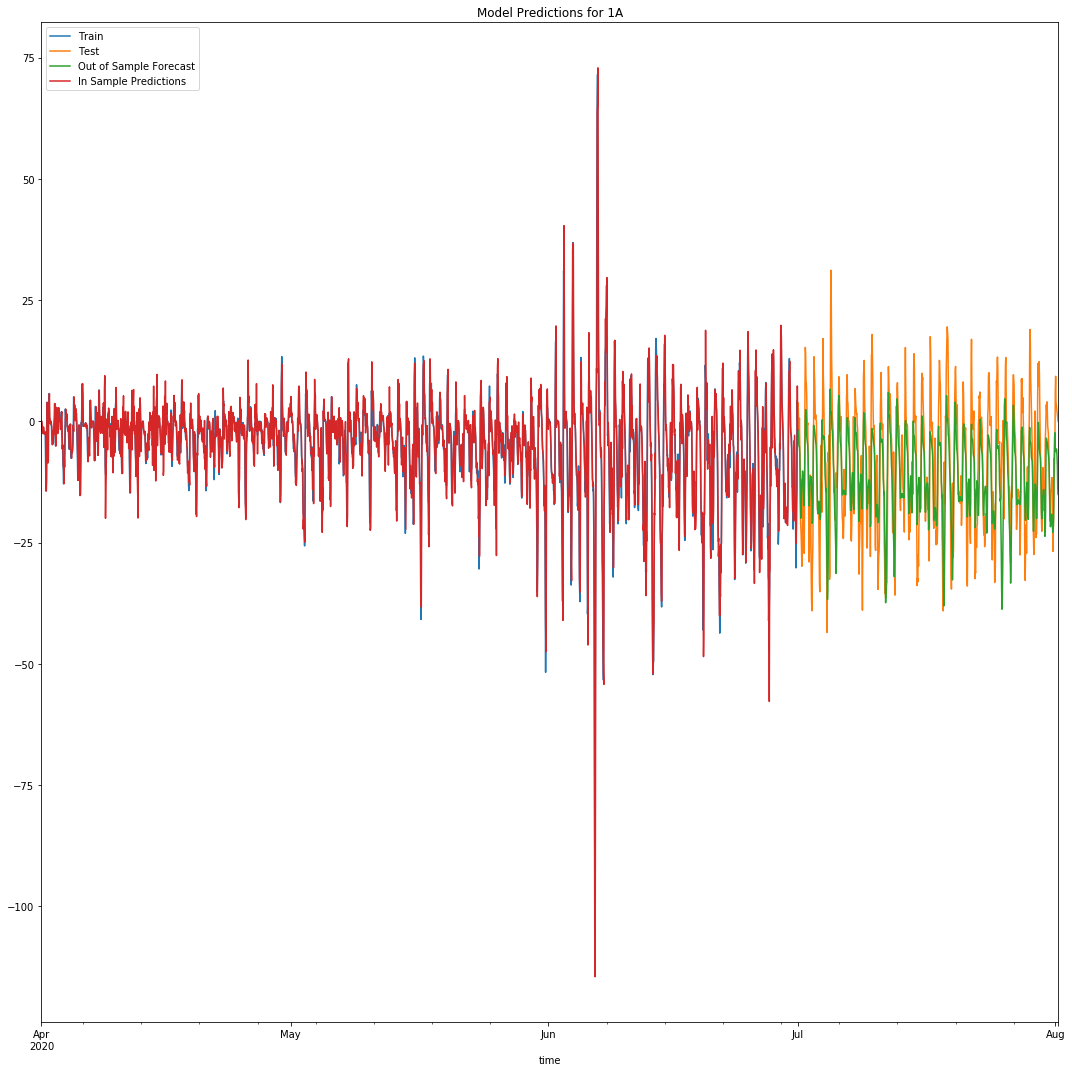

In [48]:
resampled = pd.Series(resampled['1A'])
fig, ax = v.plot_series(resampled, train_end=test_start, preds=preds_weekly, fig_size=(15,15))

## Evaluation: Model does Better Farther Out of Sample
- Metrics slightly better but not wildly, this takes much longer to run than daily
- Future improvement, combining this with a daily component would potentialy be quite interesting result
- Looking at a one day zoom in on the out of sample predictions we see the following. The bimodality from midweek commute is caught better by the weekly model (note the two humps on the green line below), but it does not track the magnitude of the morning dropoff or end of day boost indicated from previous day as well as the daily model

In [49]:
ax.set_title('Naive SARIMA model Prediction 1 Month out of Sample for ANC 1A s=weekly \n config=(0,1,1)(0,1,1,168)')
fig.savefig('../figures/weekly_out_of_sample.png')

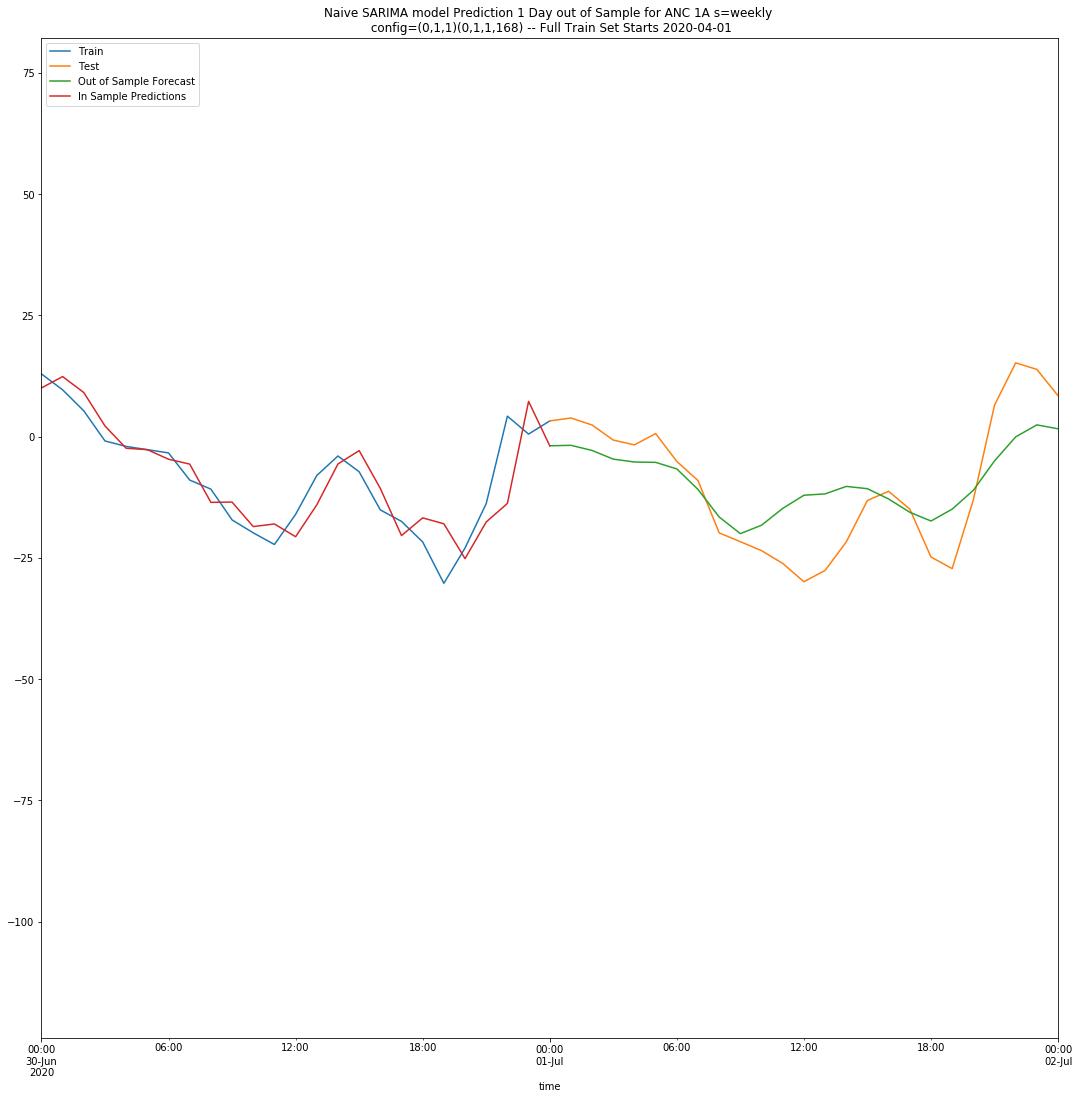

In [51]:
import datetime as dt
ax.set_xlim(ax.set_xlim([dt.date(2020, 6, 30), dt.date(2020, 7, 2)]))
ax.set_title('Naive SARIMA model Prediction 1 Day out of Sample for ANC 1A s=weekly \n config=(0,1,1)(0,1,1,168) -- Full Train Set Starts 2020-04-01')
fig.savefig('../figures/one_day_pred_no_walk_forward_weeekly.png')
fig

## The Three Hour Rolling Window May be part of the problem. Before moving forward let's take a look at simple sum of plus minus on an hourly basis (i.e. net gain/loss hourly).

- It probably also makes sense to do this at smaller intervals down to say 15 or 30 minutes, given availability of resources.

In [8]:
# Initialize engine
engine = pass

# Read in Series - Create cols list somewhere to automate this

col = '1A'

query = f"""
    SELECT time, "{col}"
    FROM plus_minus
"""

series = pd.read_sql(
    query,
    engine,
    parse_dates='time'
).set_index(
    'time'
)

# Ensure db connections are closed
engine.dispose()

In [9]:
# The Hourly Net gain/loss 
hourly = series['1A'].resample('1H').sum()

# Half_Hourly Net gain/loss
half_hourly = series['1A'].resample('30T').sum()

hourly

time
2020-04-01 00:00:00    0
2020-04-01 01:00:00   -1
2020-04-01 02:00:00   -1
2020-04-01 03:00:00   -1
2020-04-01 04:00:00    0
                      ..
2020-08-01 04:00:00    0
2020-08-01 05:00:00    0
2020-08-01 06:00:00    0
2020-08-01 07:00:00    0
2020-08-01 08:00:00    0
Freq: H, Name: 1A, Length: 2937, dtype: int64

In [59]:
half_hourly

time
2020-04-01 00:00:00    0
2020-04-01 00:30:00    0
2020-04-01 01:00:00    0
2020-04-01 01:30:00   -1
2020-04-01 02:00:00   -1
                      ..
2020-08-01 06:00:00    0
2020-08-01 06:30:00    0
2020-08-01 07:00:00    0
2020-08-01 07:30:00    0
2020-08-01 08:00:00    0
Freq: 30T, Name: 1A, Length: 5873, dtype: int64

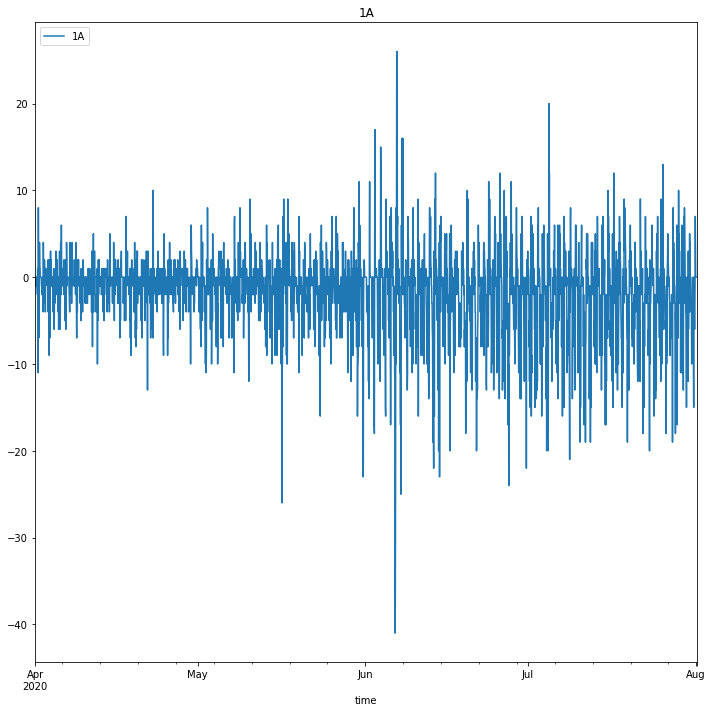

In [67]:
fig, ax = v.plot_series(hourly, preds=[])



In [69]:
# Stationary
_ = m.test_stationarity(hourly)

ADF Statistic: -5.731489
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [70]:
# Leaving aside month of July as Test Set (about 25% of data)
test_start = '2020-07-01 00:00:00'

# Train/Test Split
train = hourly[hourly.index < test_start]
test = hourly[test_start:]


# Modeling Daily seasonality
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,24))

2937 753 2184


In [71]:
result = model.fit()

## Evaluation:

- Jarque Bera is Much higher, Ljung Box improved slightly, this method introduces some negative skew that was not previously present
- Residuals appear roughly normal, however, this method does not capture even the in-sample predictions quite as well

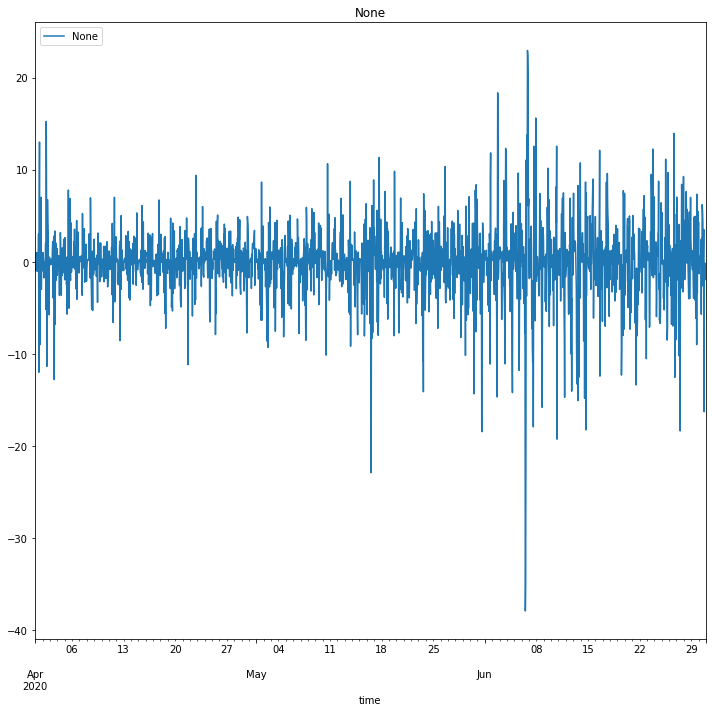

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


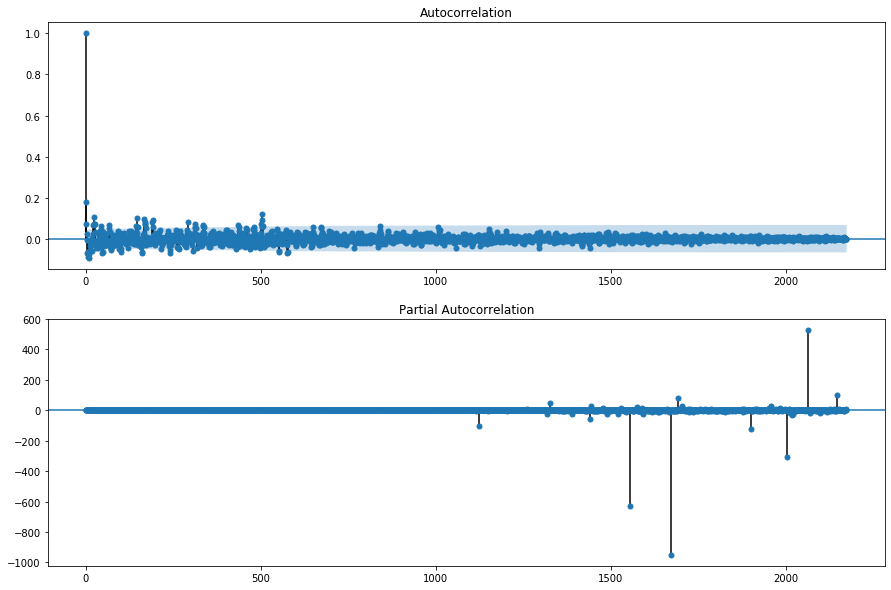

In [81]:
# Visualizing Residuals
_, _ = v.plot_series(result.resid)
v.plot_acf_pacf(result.resid, len(result.resid) - 10)


In [72]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 1A   No. Observations:                 2184
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 24)   Log Likelihood               -6051.299
Date:                            Mon, 31 Aug 2020   AIC                          12108.598
Time:                                    18:58:33   BIC                          12125.630
Sample:                                04-01-2020   HQIC                         12114.827
                                     - 06-30-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.002   -425.638      0.000      -1.004      -0.995
ma.S.L24      -0.9215      0.006   -154.188      0.000      -0.933      -0.910
sigma2        15.5118      0.184     84.489      0.000      15.152      15.872
===================================================================================
Ljung-Box (Q):                      283.62   Jarque-Bera (JB):             12026.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.66   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
preds_hourly = result.predict(start=train.index[0], end=test.index[-1], dynamic=test_start)

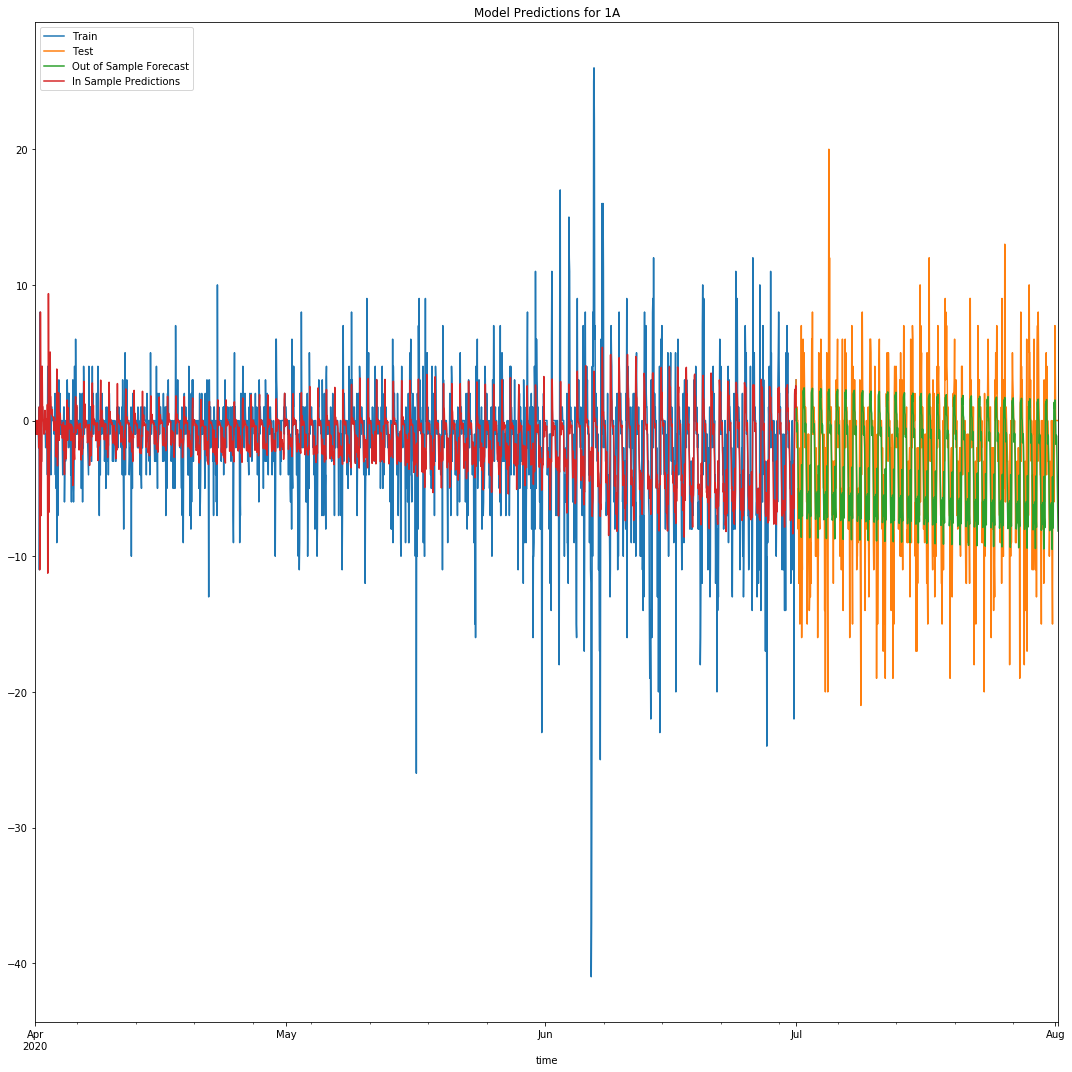

In [85]:
fig, ax = v.plot_series(hourly, train_end=test_start, preds=preds_hourly, fig_size=(15,15))

## ACF and PACF Plots for Hourly net gain/loss from/to ANC 1A support our intuition regarding optimal parameters

### Evaluation:

- There is a clear daily seasonal component present in the ACF plot, indicating a strong correlation between a given point in time, and the same times on other days (period is hourly we see generally more positive correlation at 24 hour hour intervals, interspaced with negative correlation in the middle of each 24 hour period. This indicates a seasonal component of 12, 24, etc. is likely a good starting place.

- That the PACF appears to taper in multiples of S (where S is 12) supports a seasonal MA component of 1 (Q=1 in our config).

- There are smaller, but significant bumps in correlation at the peaks in the ACF plot around every 6-8 days (144-192 hrs in the plot). This indicates there is likely also a weekly seasonality present as well. The fact that the size of this correlation is stable but decreasing slightly over time indicates there may be a very small trend component. This intuition is suppoerted by the small but locally significant outliers in PACF plot at lags roughly corresponding to 168 hour periods. LEVELUP ADD A HORIZONTAL LINE SHOWING THIS SMALL DIFFERENCE to ACF plot

- Early corresponding tapering in the ACF and PACF indicates AR(1) up to maybe AR(3) as strong starting points (p) param

- PACF persistently significant at the season period length of either 12 or 24, perhaps P=6, S=12 worth a try as max, or 3, 24

- MA (q) good starting place is 2 up to at most 3

-

- Stationarity Test indicates no differencing good bet as the data has not been differenced and appears stationarity from adfuller

- PLOT THE RESIDUALS VS fitted VALUES bruh

(3, 0, ) (3, ,24

In [154]:
500 //24

20

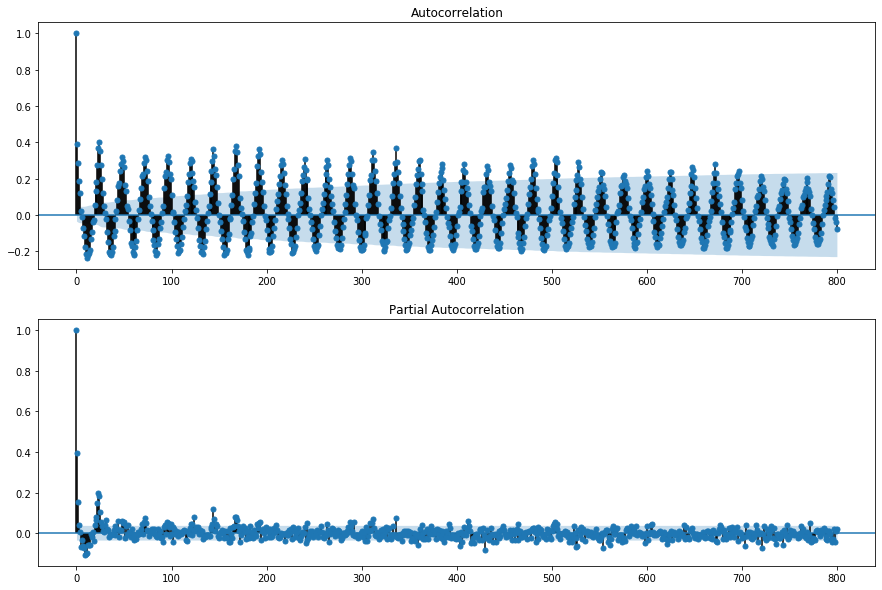

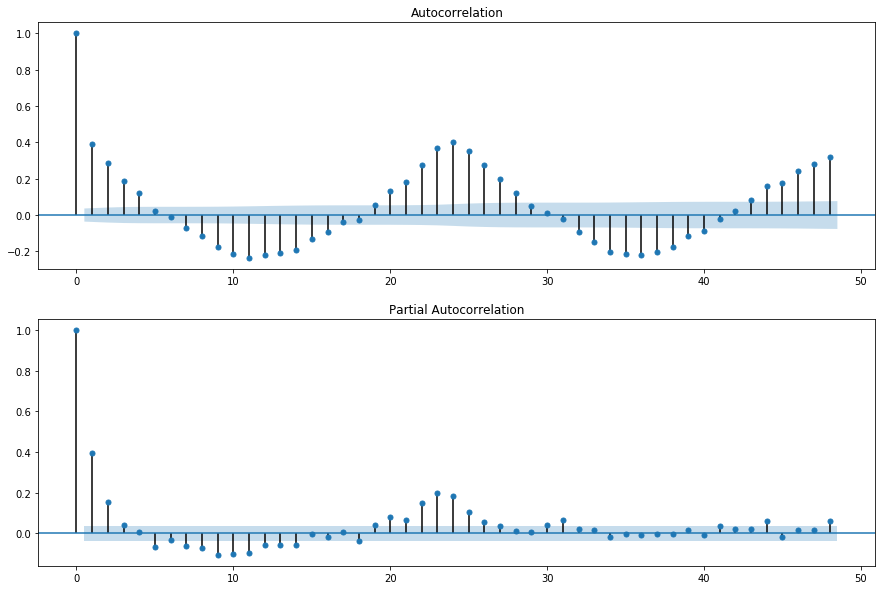

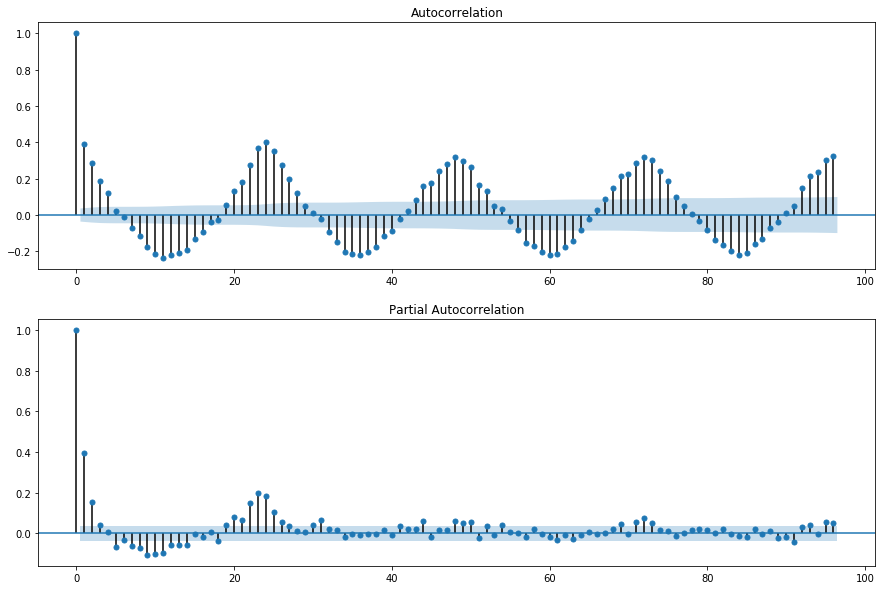

ADF Statistic: -5.731489
p-value: 0.000001
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


(-5.731488961956067,
 6.584490988940061e-07,
 26,
 2910,
 {'1%': -3.432599167616887,
  '5%': -2.8625337318595023,
  '10%': -2.5672989915093116},
 16555.40778154625)

In [152]:
v.plot_acf_pacf(hourly, 800)
v.plot_acf_pacf(hourly, 48)
v.plot_acf_pacf(hourly, 96)
m.test_stationarity(hourly)

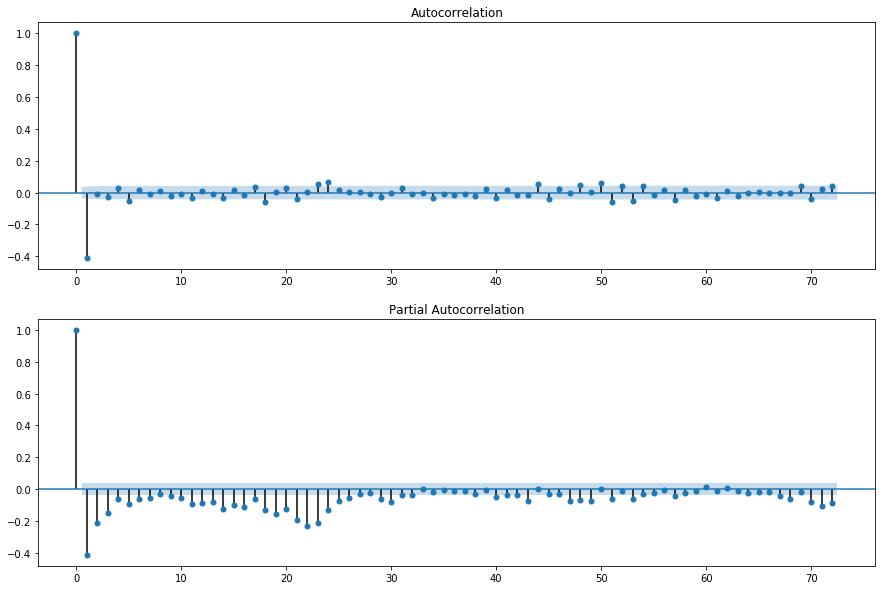

In [150]:
three_hourly = hourly.diff(1)
v.plot_acf_pacf(three_hourly[2:], 72)

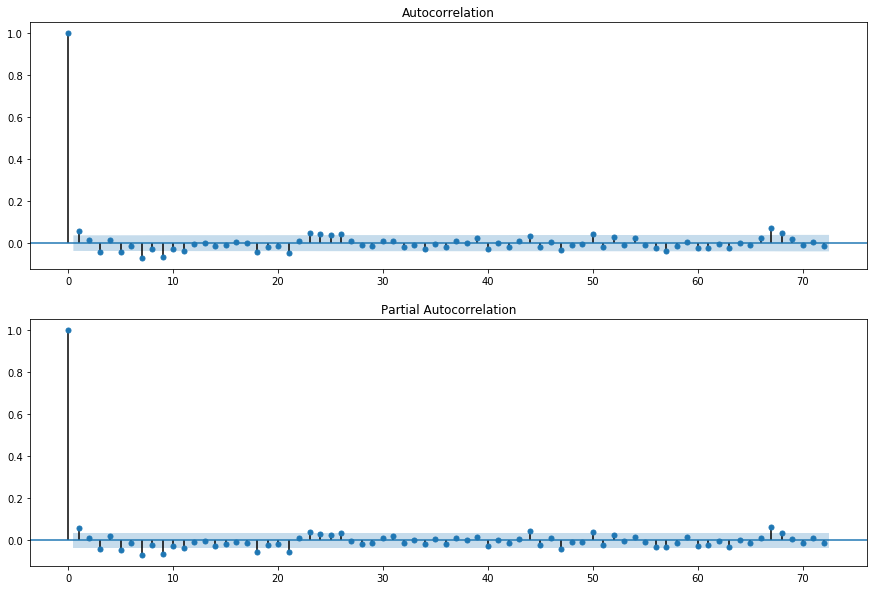

In [145]:
weekly_diff = hourly.diff(168)
v.plot_acf_pacf(weekly_diff[168:], 72)

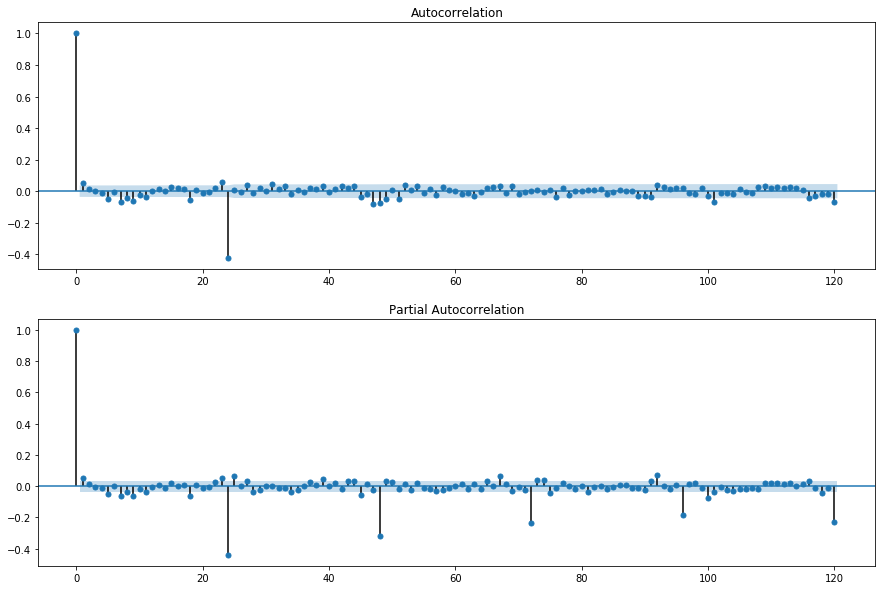

In [137]:
daily_diff = hourly.diff(24)
v.plot_acf_pacf(daily_diff[24:], 24*5)

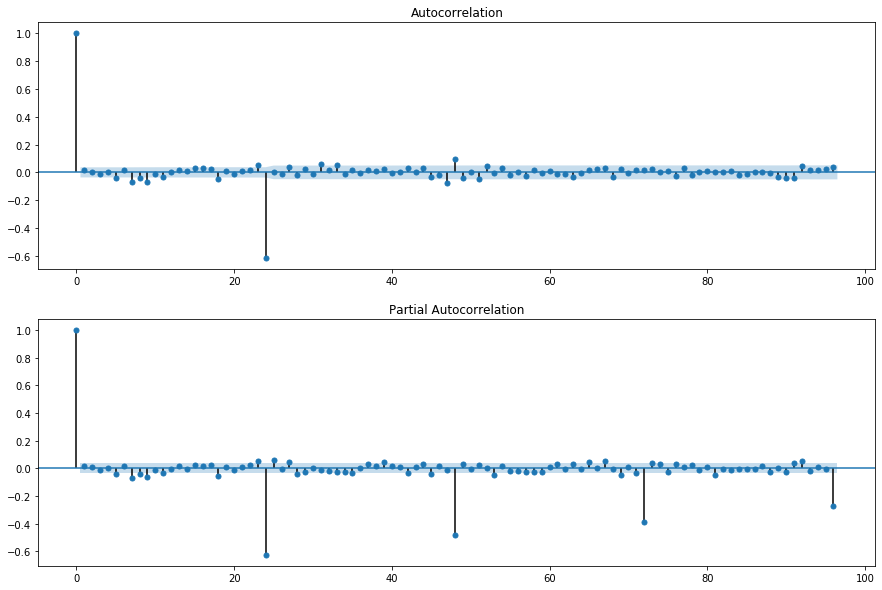

In [142]:
daily_diff2 = daily_diff[24:].diff(24)
v.plot_acf_pacf(daily_diff2[24:], 96)

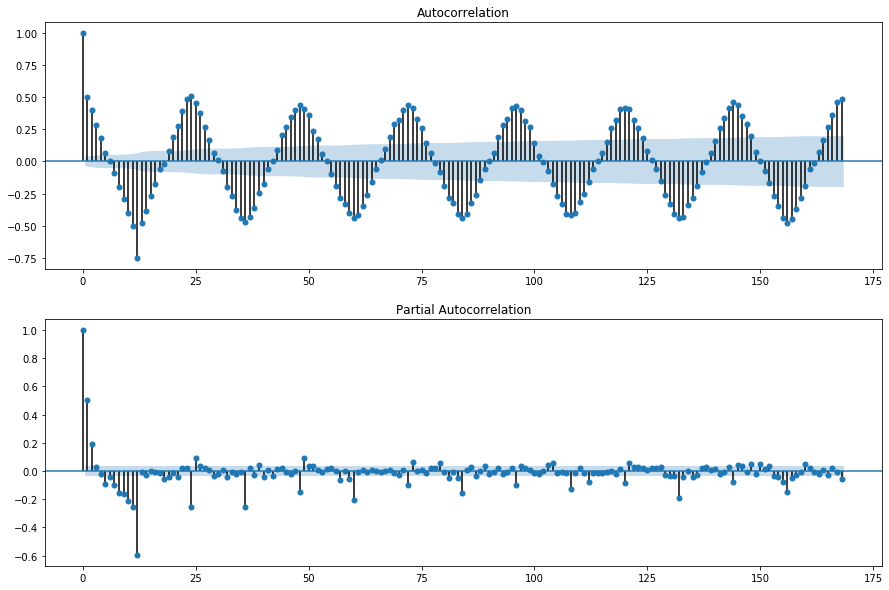

In [103]:
# Seasonal differencing is necessary
hourly_diff = hourly.diff(12)
v.plot_acf_pacf(hourly_diff[12:], 168)

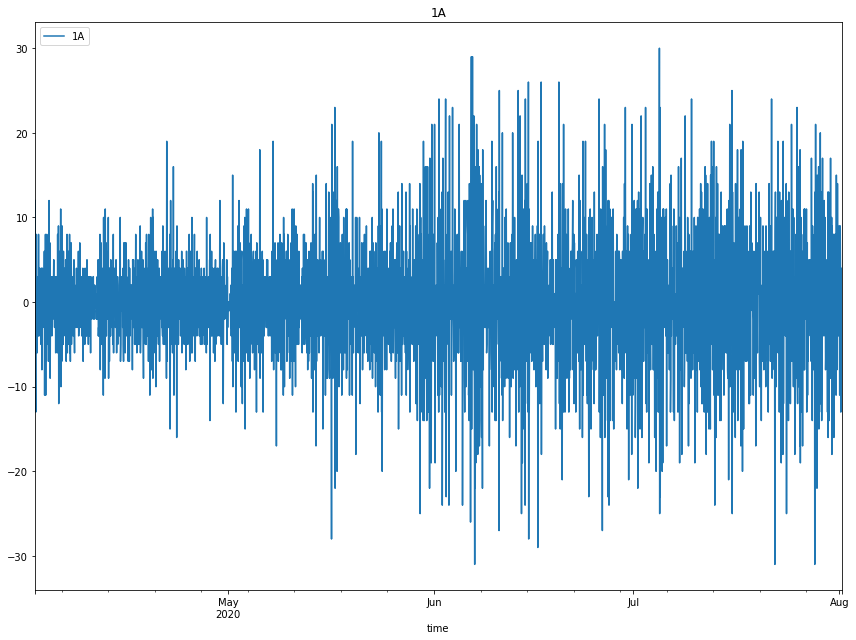

(<Figure size 864x648 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdea9ba7650>)

In [117]:
v.plot_series(hourly_diff_2[12:], fig_size=(12,9))

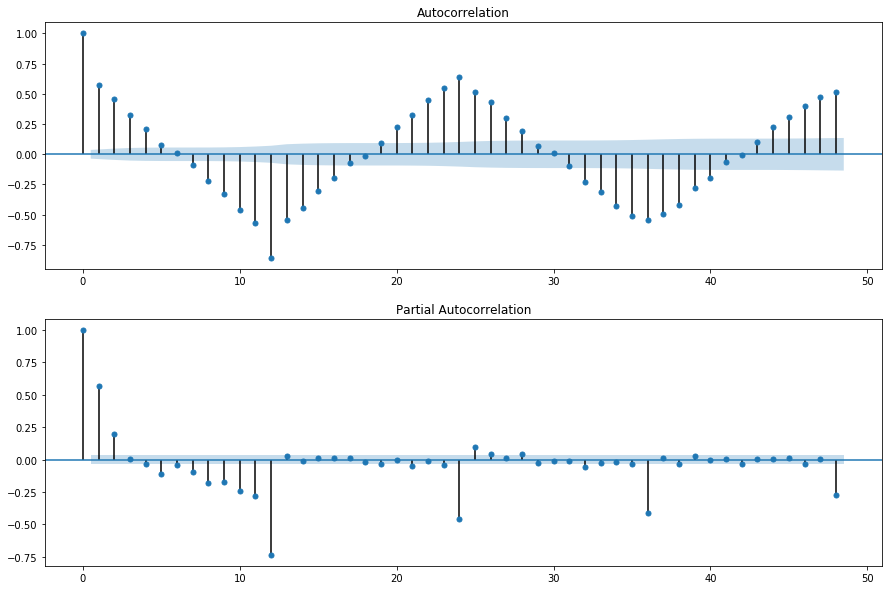

In [119]:
hourly_diff_2 = hourly_diff[12:].diff(12)
v.plot_acf_pacf(hourly_diff_2[12:], 48)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


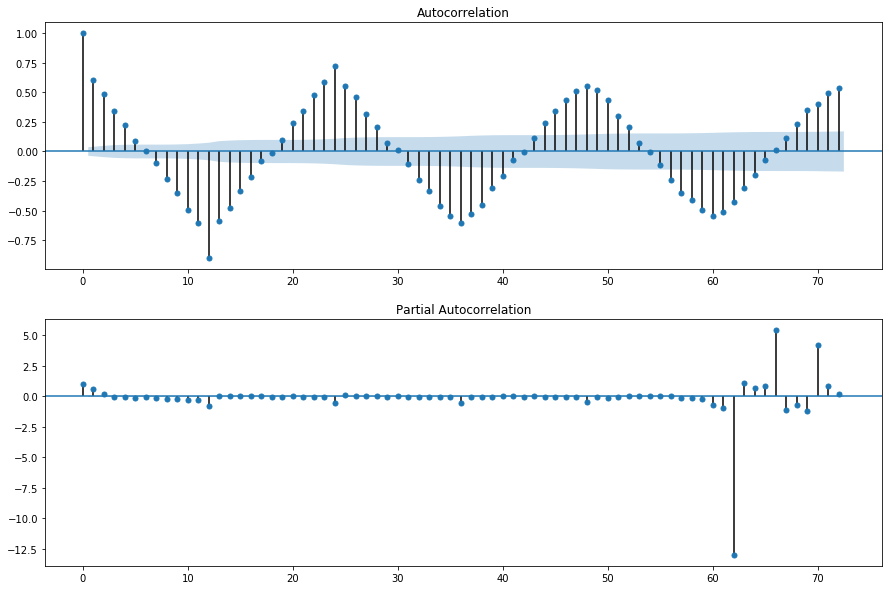

In [120]:
hourly_diff_3 = hourly_diff_2[12:].diff(12)
v.plot_acf_pacf(hourly_diff_3[12:], 72)

In [107]:
train, test, model = m.fit_sarimax(hourly, cfg=[(3,0,)])

time
2020-04-01 12:00:00    True
2020-04-01 13:00:00    True
2020-04-01 14:00:00    True
2020-04-01 15:00:00    True
2020-04-01 16:00:00    True
                       ... 
2020-08-01 04:00:00    True
2020-08-01 05:00:00    True
2020-08-01 06:00:00    True
2020-08-01 07:00:00    True
2020-08-01 08:00:00    True
Freq: H, Name: 1A, Length: 2925, dtype: bool

In [ ]:
cfgs = product(range(2,5), range(2,5), range(0,2), range(22, 29))

In [10]:
from itertools import product
ps = range(2,5)
d=1
qs = range(2,5)
Ps = range(0,5)
D = 1
Qs = range(0,3)
s = 24

parameters_list = [*product(ps, qs, Ps, Qs)]
len(parameters_list)

135

In [11]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=SARIMAX(hourly[:168*8], order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [12]:
result_table
result_table = optimizeSARIMA(parameters_list, d, D, s)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check


CPU times: user 12h 42min 53s, sys: 1min 21s, total: 12h 44min 15s
Wall time: 3h 42min 58s


In [13]:
result_table.head()

,parameters,aic
0,"(2, 2, 4, 1)",6440.001621
1,"(2, 3, 4, 1)",6440.365284
2,"(2, 2, 4, 2)",6440.502810
3,"(3, 3, 4, 2)",6441.407276
4,"(3, 2, 4, 1)",6441.463778


In [15]:
p, q, P, Q = result_table.parameters[0]

best_model=SARIMAX(hourly[:168*8], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                   1A   No. Observations:                 1344
Model:             SARIMAX(2, 1, 2)x(4, 1, [1], 24)   Log Likelihood               -3210.001
Date:                              Tue, 01 Sep 2020   AIC                           6440.002
Time:                                      02:45:17   BIC                           6491.848
Sample:                                  04-01-2020   HQIC                          6459.440
                                       - 05-26-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8291      0.454     -1.825      0.068      -1.719       0.061
ar.L2         -0.04

In [28]:
best_model.save('../models/tunedSARIMA1A_nodata.pkl', remove_data=True)

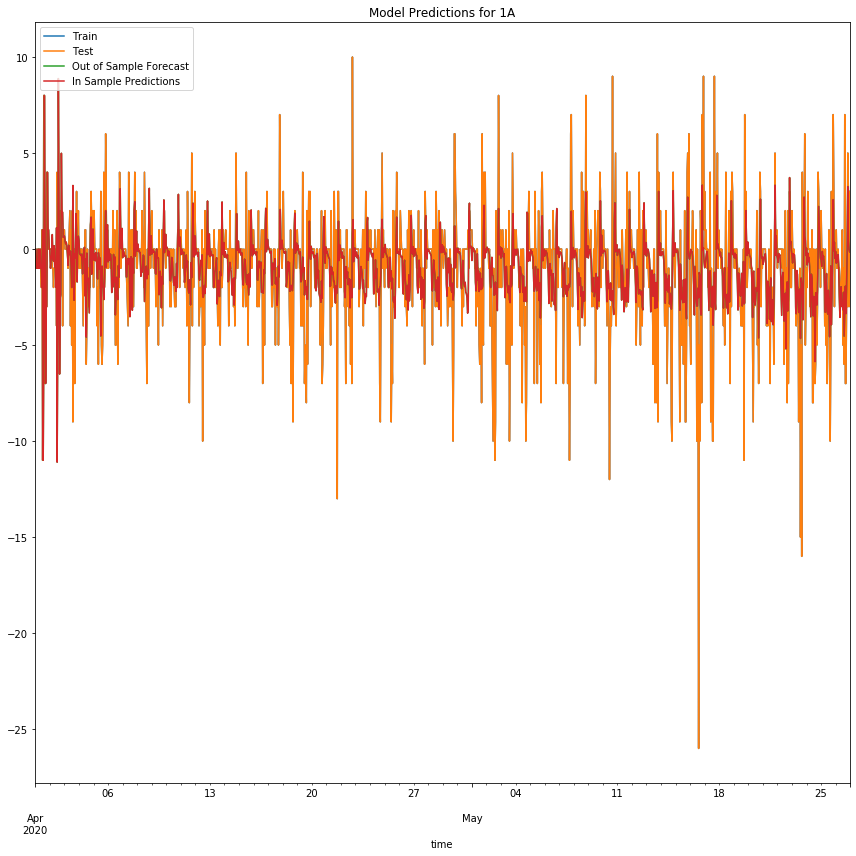

NameError: name 'dt' is not defined

In [18]:
best_preds = best_model.predict()

fig, ax = v.plot_series(hourly[:168*8], preds= best_preds, fig_size=(12,12))

ax.set_xlim(ax.set_xlim([dt.date(2020, 5, 18), dt.date(2020, 5, 23)]))



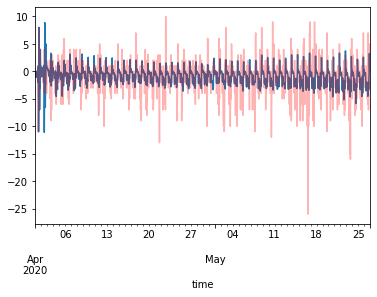

In [25]:
best_preds.plot()
hourly[:168*8].plot(color='red', alpha=0.3)

In [ ]:
engine = pass

trips_long = gpd.read_postgis('trips_long', engine, geom_col='geom_coord')
trips_long

In [ ]:
locations_raw = clean.plus_minus_locations(rides_long, 'ANC')
locations_raw

In [ ]:
%%time

three_hour_rolling = clean.cumulative_change(locations_raw, window_size='3H')
three_hour_rolling

In [ ]:
# Which series have the largest ranges? About half of these perform much differently than the others
# Worth noting that ANC's in seven and eight have very light differencing
min_max_diff = three_hour_rolling.aggregate(['min','max']).transpose()
min_max_diff.columns = ['minimum', 'maximum']
min_max_diff['range'] = min_max_diff.maximum - min_max_diff.minimum
min_max_diff.sort_values('range', ascending=False)

## There are large spikes here around for example early June, but let's see how SARIMA does, with a daily seasonal component (24 hours per day)

In [ ]:
viz.plot_series(three_hour_rolling['5D'],train_end='2020-07-01')

In [ ]:
series = three_hour_rolling['5D'].resample('1H').mean()
viz.plot_series(series,train_end='2020-07-01')

In [ ]:
series = three_hour_rolling['1A'].resample('1H').mean()

# Leaving aside month of July as a Test Set, this is about 25% of the data
test_start = '2020-07-01 00:00:00'

# Make the train/test splits
train = series[series.index < test_start]
test = series[test_start:]

# Checking output lens add up to len of series (they do)
print(len(series), len(test), len(train))

# model
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,24))

In [ ]:
# Fit Model
result = model.fit()

In [ ]:
preds = result.predict(start=train.index[0], end=test.index[-1], dynamic=test_start)

## SARIMAX crushes it in-sample, even catching huge spikes, it does much less well as distance out of sample decreases

- Since our business use case is for fleet rebalancing on an intraday basis rather than predicting out of sample forecast one month out, it seems quite fair to use walk-forward modeling here
- Future improvement: would reaaaaallly like to add a seasonal weekly component with s=168 (i.e. both daily s=24, and weekly s=168)

In [ ]:
fig, ax = viz.plot_series(series, train_end=test_start, preds=preds, fig_size=(15,15))

In [ ]:
ax.set_title('Naive SARIMA model Prediction 1 Month out of Sample for ANC 1A \n config=(0,1,1)(0,1,1,24)')
fig.savefig('../figures/declining_out_of_sample.png')

In [ ]:
ax.set_xlim(ax.set_xlim([dt.date(2020, 6, 30), dt.date(2020, 7, 2)]))
ax.set_title('Naive SARIMA model Prediction 1 Day out of Sample for ANC 1A \n config=(0,1,1)(0,1,1,24) -- Full Train Set Starts 2020-04-01')
fig.savefig('../figures/one_day_pred_no_walk_forward.png')
fig

In [ ]:
summary_daily1A = result.summary()
summary_daily1A

## Attempting a Weekly Seasonal with s=168

In [ ]:
series = three_hour_rolling['1A'].resample('1H').mean()

# Leaving aside month of July as a Test Set, this is about 25% of the data
test_start = '2020-07-01 00:00:00'

# Make the train/test splits
train = series[series.index < test_start]
test = series[test_start:]

# Checking output lens add up to len of series (they do)
print(len(series), len(test), len(train))

# model
model = SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,168))

In [ ]:
result = model.fit()

In [ ]:
preds = result.predict(start=train.index[0], end=test.index[-1], dynamic=test_start)

In [ ]:
recent_geo.started_at.value_counts().head(60)

In [ ]:
cleaned_recent[cleaned_recent.started_at > cleaned_recent.ended_at]

In [ ]:
recent_geo[recent_geo.started_at.isin(recent_geo.started_at.value_counts().head(60).index) & (recent_geo.duration_seconds == 1118.0)].start_station_name.value_counts()

In [ ]:
recent_geo[recent_geo.started_at == '2020-07-23 11:24:54']

In [ ]:
historical = pd.concat(raw_dfs[:-4])
historical